In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform, exposure, filters, feature, color, data
import os

In [25]:
def imNormalize(image):
    if len(image.shape)==2:
        r = image
        g = image
        b = image
    else:
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
    
    r = r - r.min()
    r = r / r.max()
    r = np.uint8(r * 255)
    
    g = g - g.min()
    g = g / g.max()
    g = np.uint8(g * 255)
    
    b = b - b.min()
    b = b / b.max()
    b = np.uint8(b * 255)
    
    return np.stack((r,g,b),axis=2) 


def colorHistogram(image):
    #image = imNormalize(image)
    image = color.rgb2hsv(image)
    
    h1 = exposure.histogram(image[:,:,0])
    h2 = exposure.histogram(image[:,:,1])
    h3 = exposure.histogram(image[:,:,2])
    h = np.concatenate((h1[0],h2[0],h3[0]), axis = None)
    h = h / (image.shape[0]*image.shape[1])
    return np.array(h)

In [26]:
path = 'data/caltech-101/101_ObjectCategories'
classes = os.listdir(path)

newlist = []
for item in classes:
    try:
        os.listdir(path+'/'+item)
        newlist.append(item)
    except:
        continue
classes = newlist
classes

['gerenuk',
 'hawksbill',
 'headphone',
 'ant',
 'butterfly',
 'lamp',
 'strawberry',
 'water_lilly',
 'chandelier',
 'dragonfly',
 'crab',
 'pagoda',
 'dollar_bill',
 'emu',
 'inline_skate',
 'platypus',
 'dalmatian',
 'cup',
 'airplanes',
 'joshua_tree',
 'cougar_body',
 'grand_piano',
 'trilobite',
 'brontosaurus',
 'wild_cat',
 'pigeon',
 'dolphin',
 'soccer_ball',
 'wrench',
 'scorpion',
 'flamingo_head',
 'nautilus',
 'accordion',
 'cougar_face',
 'pyramid',
 'camera',
 'barrel',
 'schooner',
 'cellphone',
 'panda',
 'revolver',
 'lobster',
 'menorah',
 'lotus',
 'stapler',
 'crocodile',
 'chair',
 'helicopter',
 'minaret',
 'starfish',
 'ceiling_fan',
 'ketch',
 'mayfly',
 'wheelchair',
 'bass',
 'yin_yang',
 'crocodile_head',
 'saxophone',
 'beaver',
 'mandolin',
 'bonsai',
 'Leopards',
 'car_side',
 'ibis',
 'electric_guitar',
 'kangaroo',
 'stegosaurus',
 'ferry',
 'snoopy',
 'umbrella',
 'rhino',
 'okapi',
 'watch',
 'brain',
 'gramophone',
 'scissors',
 'rooster',
 'cannon'

In [27]:
myclasses = classes
myclasses.remove('BACKGROUND_Google')
myclasses = myclasses[:10]

In [28]:
traindata = []
testdata = []
trainlabels = []
testlabels = []
trainfilenames = []
testfilenames = []
numtrain = 20

for classnum in range(len(myclasses)):
    folder = path + '/' + myclasses[classnum]
    filelist = os.listdir(folder)
    np.random.shuffle(filelist)
    for i in range(len(filelist)):
        filename = folder + '/' + filelist[i]
        image = io.imread(filename)
        image = imNormalize(image)
        image = transform.resize(image,[256,256])
        fd1 = feature.hog(image, orientations=8, pixels_per_cell=(32, 32),
                    cells_per_block=(1, 1), visualize=False, channel_axis=2)
        fd2 = colorHistogram(image)
        fd = np.concatenate([fd1, fd2])
        if i<numtrain:
            traindata.append(fd)
            trainlabels.append(classnum)
            trainfilenames.append(filename)
        else:
            testdata.append(fd)
            testlabels.append(classnum)
            testfilenames.append(filename)
    print(classnum,end='\t')

traindata = np.array(traindata)
testdata = np.array(testdata)
trainlabels = np.array(trainlabels)
testlabels = np.array(testlabels)
trainfilenames = np.array(trainfilenames)
testfilenames = np.array(testfilenames)
    
    

0	1	2	3	4	5	6	7	8	9	

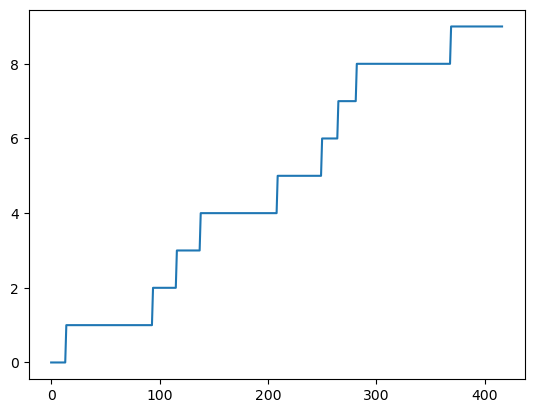

In [29]:
plt.plot(testlabels)


In [30]:
traindata.shape

(200, 1280)

In [31]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=199,whiten=True)
# traindata1 = pca.fit_transform(traindata)
# testdata1 = pca.transform(testdata)

In [32]:
from sklearn.svm import LinearSVC

model1 = LinearSVC()
model1.fit(traindata,trainlabels)
guessedlabels = model1.predict(testdata)


/Users/banerji/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


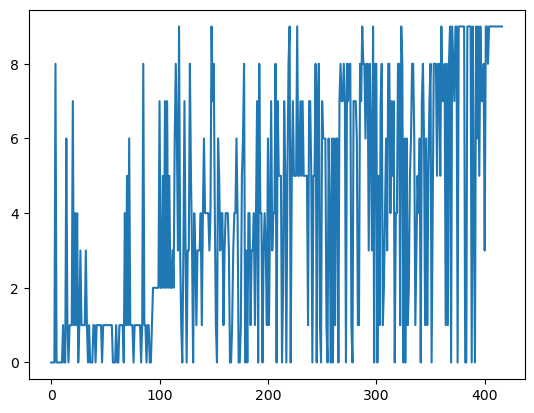

In [33]:
plt.plot(guessedlabels)

<AxesSubplot:>

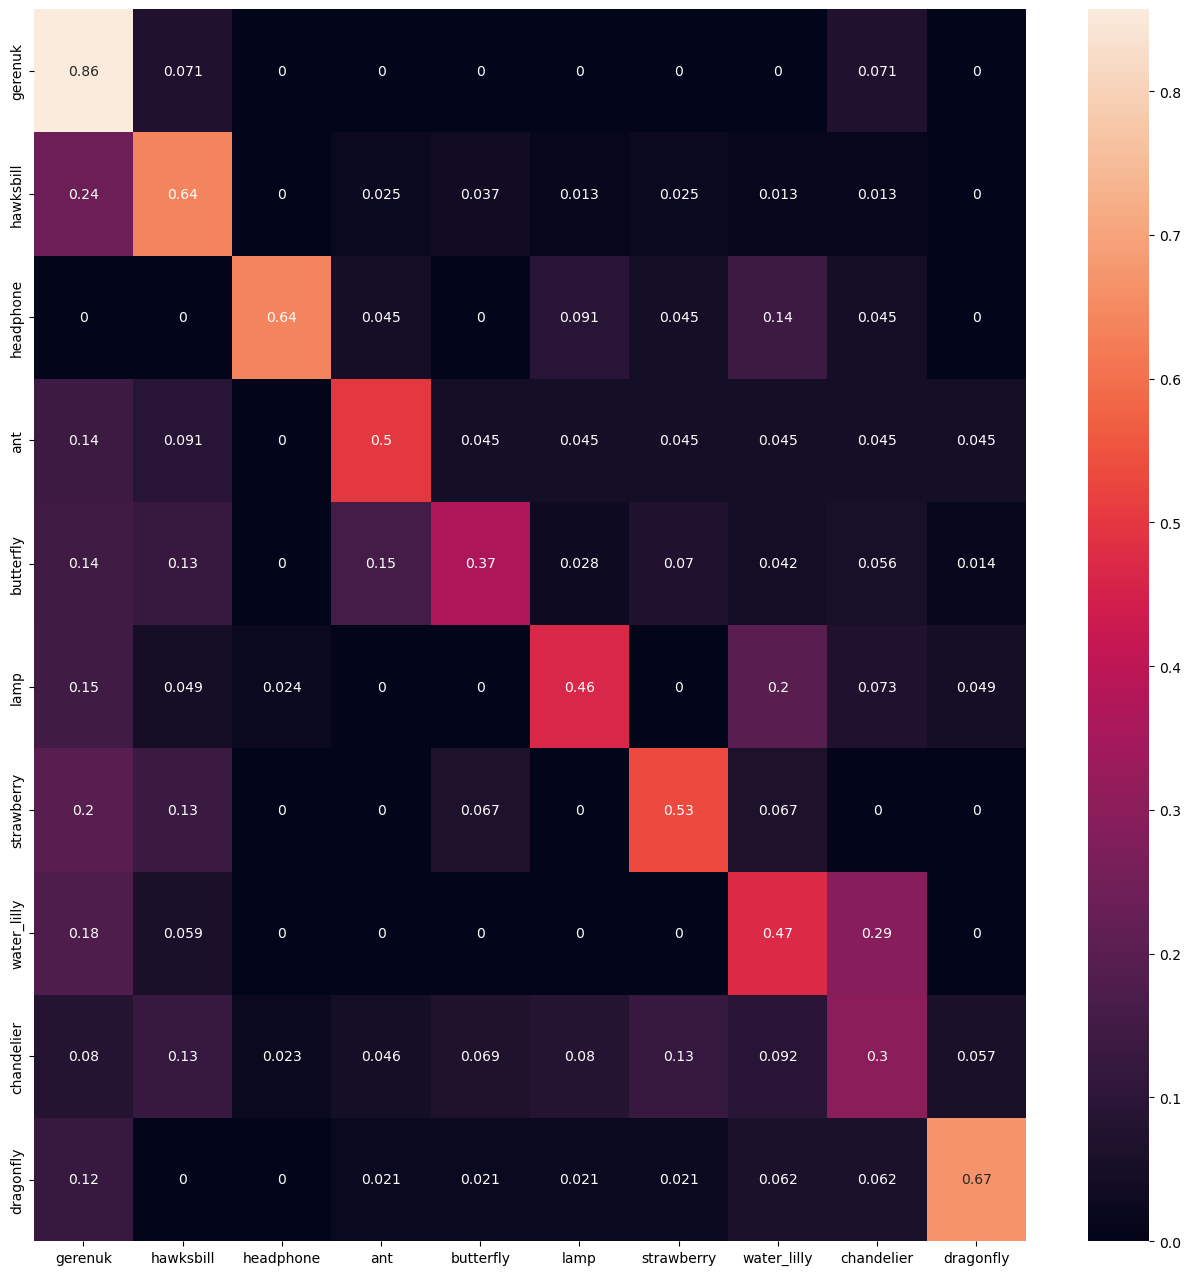

In [34]:
#Visualize performance by Normalized confusion matrix
import seaborn as sn
import pandas as pd
numClasses = len(myclasses)

conf = np.zeros([numClasses,numClasses])

for image in range(len(testlabels)):
    real = testlabels[image]
    guess = guessedlabels[image]
    conf[real,guess] = conf[real,guess] + 1
 
rowsums = np.sum(conf,1)
rowsums = np.reshape(rowsums,[numClasses,1])
rowsums = np.repeat(rowsums,numClasses, axis = 1)
conf = conf / rowsums
df_cm = pd.DataFrame(conf, index = [i for i in myclasses],
                  columns = [i for i in myclasses])
plt.figure(figsize = (16,16))
sn.heatmap(df_cm, annot=True)

In [35]:
print(np.average(np.diag(conf)))

0.5430057120758188


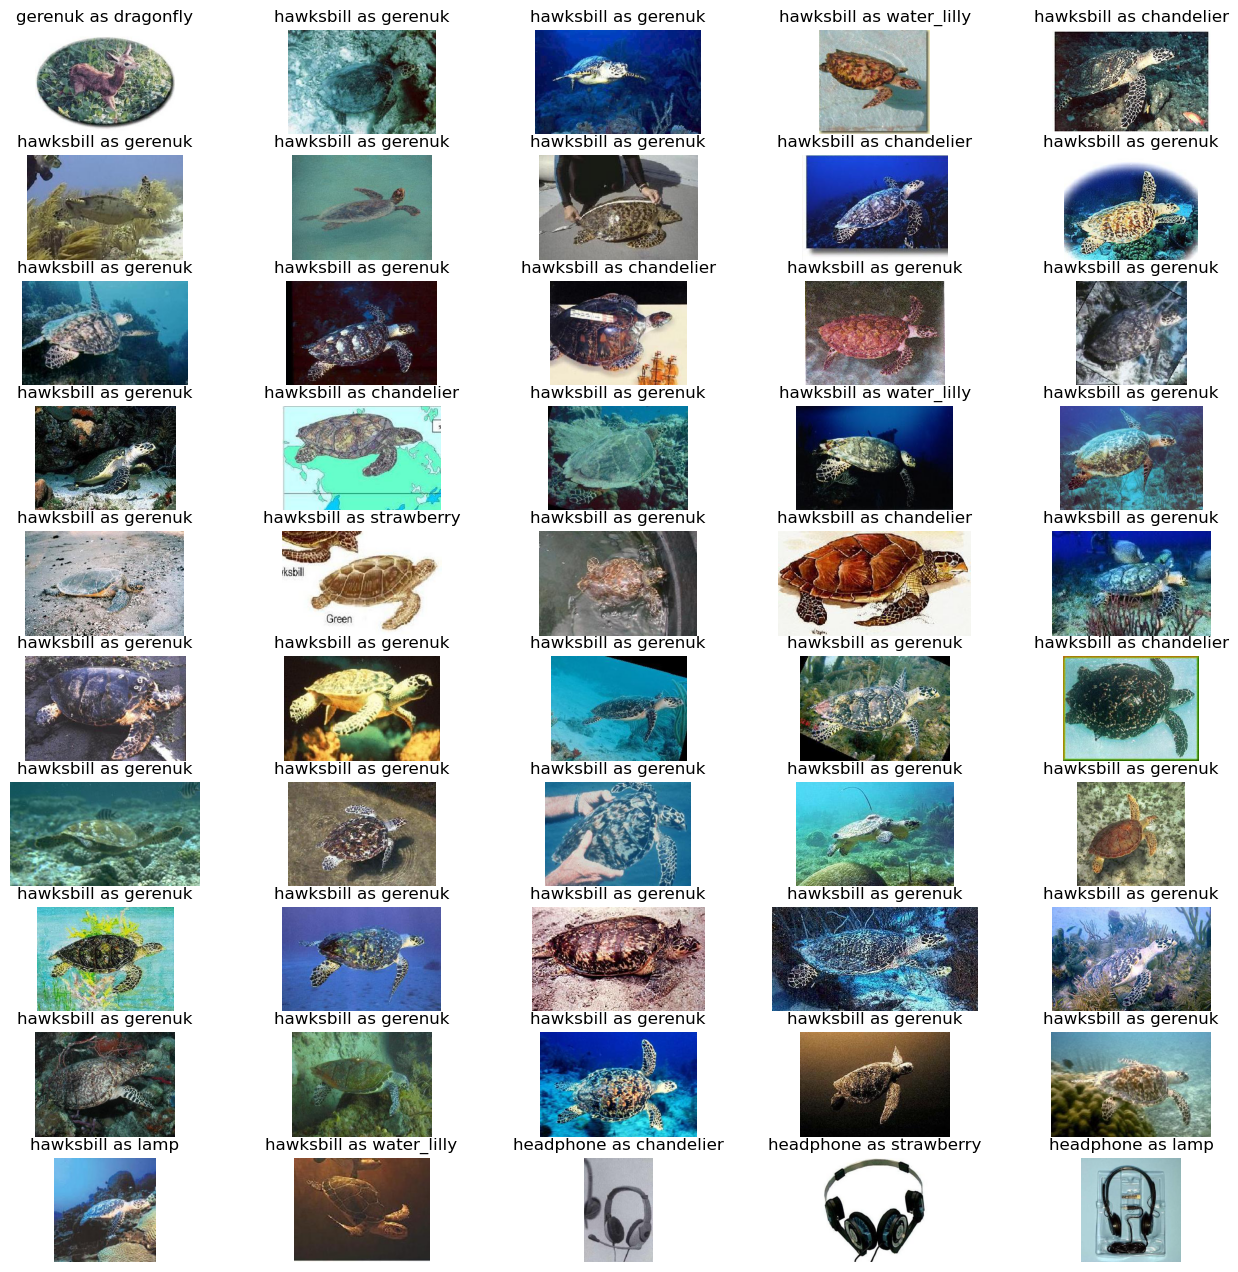

In [24]:
#Visualize wrong results
rows = 10
cols = 5
wrong = np.not_equal(guessedlabels,testlabels)
fig = plt.figure(figsize=(16, 16))
count = 0
for index in range(len(wrong)):
    if wrong[index]:
        count = count +1
        image = io.imread(testfilenames[index])
        temp = fig.add_subplot(rows, cols ,count)
        temp.imshow(image)
        temp.axis('off')
        temp.title.set_text(myclasses[testlabels[index]]+' as '+myclasses[guessedlabels[index]])
    if count==rows*cols:
        break
plt.show()